In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("data/TAQ_30Min_AAPL_2023_normalized.csv")
df.index = df.datetime
N_day = 13
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2873 entries, 2023-02-14 09:30:00 to 2023-12-29 15:30:00
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             2873 non-null   object 
 1   TURNOVER             2873 non-null   float64
 2   Normalized_TURNOVER  2873 non-null   float64
dtypes: float64(2), object(1)
memory usage: 89.8+ KB


In [3]:
def predict_volumes(mu, Sigma, true_volumes):
    """
    param mu: means
    param Sigma: covariance
    param true_volumes: true volumes, i.e., means[0] predicts true_volumes[0]
    """
    n= mu.shape[0]
    
    predictions = np.zeros(n)
    predictions[0] = mu[0]
    
    for i in range(1,n):
        ### following Wikipedia's notation, we observe x2 and update x1
        
        mu1 = mu[i:]
        mu2 = mu[:i]
        a = true_volumes[:i]
        
        mu_bar = mu[i:]
        Sigma_12 = Sigma[i:, :i]
        Sigma_22 = Sigma[:i, :i]
        Sigma_21 = Sigma[:i, i:]
#         assert Sigma_21 == Sigma_12.T

        mu_bar = mu1 + Sigma_12 @ np.linalg.inv(Sigma_22) @ (a-mu2)
        
        predictions[i] = mu_bar[0]
    
    return predictions

In [17]:
X1 = pd.DataFrame(df["Normalized_TURNOVER"])
X1.index = pd.to_datetime(X1.index)
X1 = X1[~(((X1.index.hour < 9) & (X1.index.minute < 30)) | (X1.index.hour >= 16))]
X1 = X1[X1.index.dayofweek < 5]

In [6]:
grouped = X1.groupby(pd.Grouper(freq='1d'))
bad_ts = []
to_remove = [pd.Timestamp("2023-07-03"), pd.Timestamp("2023-11-24"), pd.Timestamp("2023-12-24"), pd.Timestamp("2023-12-31")]

for (t,g) in grouped:
    # This removes any days where the exchange closes early, and the days listed in to_remove
    # note that this is necessary because while some of these outlier days have truncated data, others don't
    # so we can't just detect and drop truncated data
    if (g.shape[0] != N_day and g.shape[0] != 0) or (t in to_remove):
        print("Bad timestamp: {} has size {}".format(t, g.shape[0]))
        bad_ts.append(t)
            
# Delete the days that have truncated data
for bad_t in bad_ts:
    nxt = pd.Timestamp(year=bad_t.year, month=bad_t.month, day=bad_t.day+1)
    X1 = X1[~((X1.index < nxt) & (X1.index > bad_t))]

Bad timestamp: 2023-07-03 00:00:00 has size 13
Bad timestamp: 2023-11-24 00:00:00 has size 13
Bad timestamp: 2023-12-24 00:00:00 has size 0


In [7]:
N = X1.shape[0]
X = X1.to_numpy().reshape(int(N/N_day), N_day)
X.shape

(219, 13)

In [8]:
#def lag_col(pd_col, i):
#    d = {"VOLUME" : "VOLUME_{}".format(N_day-i)}
#    pd_col.rename(columns=d, inplace=True)
#    return pd_col.shift(-i)[:-N_day-1]

#X1 = pd.concat([lag_col(pd.DataFrame(df["VOLUME"]), i) for i in range(N_day)], axis=1)
#X = X1.to_numpy() # this constructs a lagged matrix but I don't know why this makes sense

In [9]:
#np.random.seed(0)
def train_and_predict(X):
    A = np.random.normal(size=(N_day,N_day))

    Sigma = A@A.T

    mu = X.mean(axis=0)

    benchmark_error = ((X-mu)**2).mean()
    # so we would do N_day-1 updates per row since we have N_day columns 

    mu = X.mean(axis=0)
    Sigma = np.cov(X[:-1].T)
    true_volumes = X[-1]

    pred = predict_volumes(mu, Sigma, true_volumes)
    return mu, pred, true_volumes

mu, pred, true_volumes = train_and_predict(X)
print(f"MSE percent without mean update: {(((mu-true_volumes)/true_volumes)**2).mean()}")
print(f"MSE percent with mean update: {(((pred-true_volumes)/true_volumes)**2).mean()}")

MSE percent without mean update: 0.2429352481563997
MSE percent with mean update: 0.17172641245068007


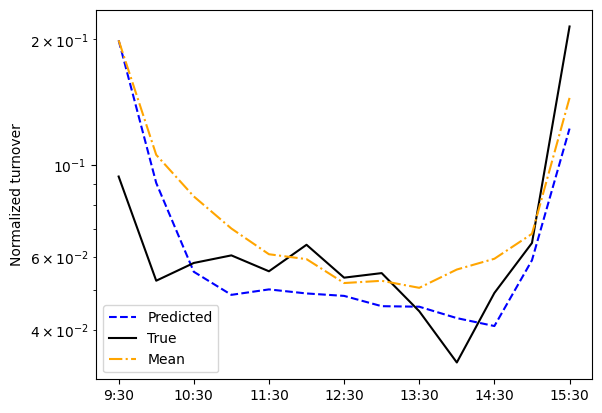

In [10]:
plt.semilogy(range(N_day), pred, label="Predicted", linestyle="--", color="blue")
plt.semilogy(range(N_day), true_volumes, label="True", color="black")
plt.semilogy(range(N_day), mu, label="Mean", color="orange", linestyle="-.")

daily_labels = ["9:30", "10:30", "11:30", "12:30", "13:30", "14:30", "15:30",]
plt.xticks(ticks=range(0, N_day, 2), labels=daily_labels)
plt.legend(); plt.ylabel("Normalized turnover")
plt.savefig("prediction.pdf")

## Visualization of data
This isn't any type of analysis, it's just a good plot for our presentation

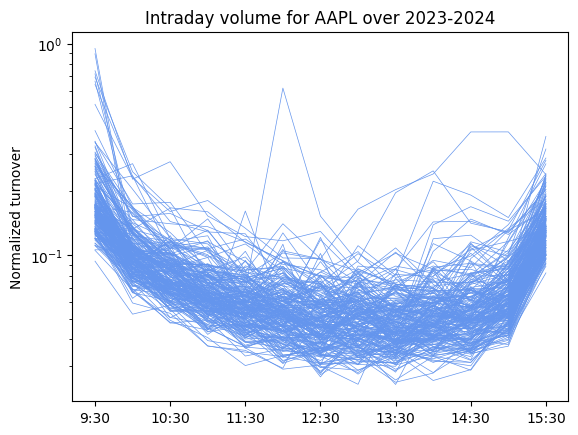

In [12]:
for d in range(X.shape[0]):
    plt.semilogy(X[d,:], linewidth=0.5, color="cornflowerblue")

plt.xticks(ticks=range(0, N_day, 2), labels=daily_labels)
plt.ylabel("Normalized turnover")
plt.title("Intraday volume for AAPL over 2023-2024")
plt.savefig("data_visualization.pdf")
plt.show()

## Analysis
(evaluate how adding more rows of data improves the MSE)

In [13]:
T = X.shape[0]
errors = np.zeros(T - N_day)
errors_mean = np.zeros(T - N_day)

In [14]:
# This does a sort of rolling test where we start at N_day rows and as the year progresses, we add more rows
for d in range(N_day, T):
    mu_d, pred_d, true_volumes_d = train_and_predict(X[0:d+1,:])
    errors_mean[d-N_day] = (((mu_d    - true_volumes_d)/true_volumes_d)**2).mean()
    errors[d-N_day]      = (((pred_d - true_volumes_d)/true_volumes_d)**2).mean()

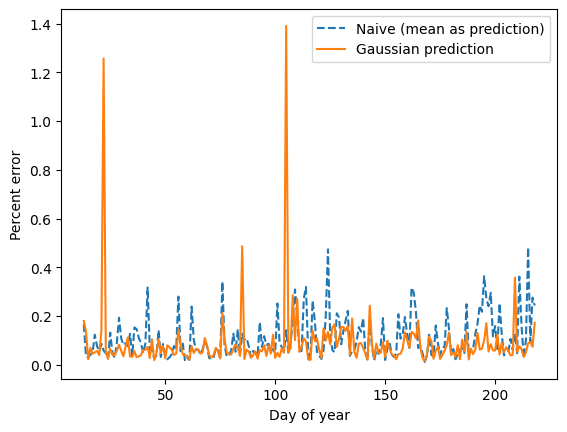

In [15]:
plt.plot(range(N_day, T), errors_mean, label="Naive (mean as prediction)", linestyle="--")
plt.plot(range(N_day, T), errors, label="Gaussian prediction")
plt.xlabel("Day of year"); plt.ylabel("Percent error")
plt.legend()
plt.savefig("gaussian_errors_year.pdf")

In [16]:
sum(X1[X1["Normalized_TURNOVER"] <= 0]["Normalized_TURNOVER"])

0